#  Imageto-Image Translation with Conditional Adversarial Networks

**image-to-image  translation** can be define as the task of translating one representation of an image into another representation such as the conversion of black and white photographs to color photographs, satellite images to map images etc.

Pix2Pix is a Generative Adversarial Network for performing image-to-image translation trained on paired examples. It is a general approach based on the conditional generative adversarial network which provides control over the image that is generated. With Pix2Pix GAN the generation of an image is conditional on a sorce image (input).


<b style='color:blue'>**Pix2pix model is a variant of the conditional GAN that uses U-Net-based architecture as it generator and a convolutional PatchGAN classifier, which only penalizes structure at the scale of image patches as it discriminator.**</b>
Unlike a standard GAN model which takes points from the latent space as input, the Pix2pix GAN generator model takes an image as input and instead, the source of randomness is provided in the form of dropout layers, applied on several layers of the generator at both training and test time.

# PatchGAN Discriminator Model

The discriminator model takes an image from the source domain and an image from the target domain and predicts the likelihood of whether the image from the target domain is a real or generated version of the source image.

<b style='color:brown'>In order to model high-frequencies, it is sufficient to restrict our attention to the structure in local image patches. Therefore, we design a discriminator architecture – **which we term a PatchGAN** that only penalizes structure at the scale of patches. This discriminator tries to classify if each $N ×N$ patch in an image is real or fake. We run this discriminator convolutionally across the image, averaging all responses to provide the ultimate output of D. [ Image-to-image translation with conditional adversarial networks by Isola et al. (2017)](https://arxiv.org/abs/1611.07004)
 </b>


**PatchGAN** designed to classify patches of an input image as real or fake, rather than the entire image

# GENERATOR
The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder and decoder 

The generator model is trained using both the adversarial loss for the discriminator model and the L1 or mean absolute pixel difference between the generated translation of the source image and the expected target image


we Jointly train generator G and discriminator D with a minimax game
$$ min_{G}max_{D} V(D,G)=-\left[ E_{x \sim P_{data}} log D(x,y)  + E_{z \sim p(z)} log (1-D(x,G(x,z)) \right] + \lambda L_{1} $$
   
where the $L_{1}$ distance is given by
$$L_{1}=E\left[|| y-G(x,z)||_{1} \right] $$
 

In [1]:

import os
import pathlib
import time
import datetime
from tensorflow import keras as K
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display

In [2]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]
#dataset_name = "edges2handbags"

In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz",origin=_URL,extract=True)
path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [4]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/arize/.keras/datasets/cifar-10-batches-py'),
 WindowsPath('C:/Users/arize/.keras/datasets/cifar-10-batches-py.tar.gz'),
 WindowsPath('C:/Users/arize/.keras/datasets/cifar-100-python'),
 WindowsPath('C:/Users/arize/.keras/datasets/cifar-100-python.tar.gz'),
 WindowsPath('C:/Users/arize/.keras/datasets/facades'),
 WindowsPath('C:/Users/arize/.keras/datasets/facades.tar.gz'),
 WindowsPath('C:/Users/arize/.keras/datasets/fashion-mnist'),
 WindowsPath('C:/Users/arize/.keras/datasets/flower_photos'),
 WindowsPath('C:/Users/arize/.keras/datasets/flower_photos.tar.gz'),
 WindowsPath('C:/Users/arize/.keras/datasets/mnist.npz'),
 WindowsPath('C:/Users/arize/.keras/datasets/modelnet.zip'),
 WindowsPath('C:/Users/arize/.keras/datasets/ModelNet10'),
 WindowsPath('C:/Users/arize/.keras/datasets/__MACOSX')]

In [5]:
sample_image = tf.io.read_file(str(PATH / 'train/2.jpg'))
sample_image = tf.image.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


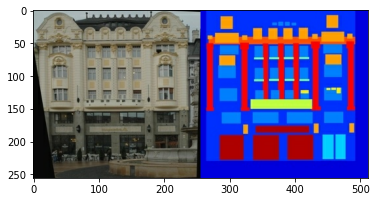

In [6]:
plt.figure()
plt.imshow(sample_image)

In [7]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    
    width = tf.shape(image)[1]
    half_width = width // 2
    
    input_image = image[:, half_width:, :]
    real_image = image[:, :half_width, :]
    
    input_image = tf.cast(input_image, dtype=tf.float32)
    real_image = tf.cast(real_image, dtype=tf.float32)
    return input_image, real_image

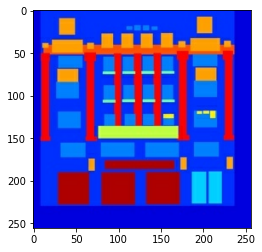

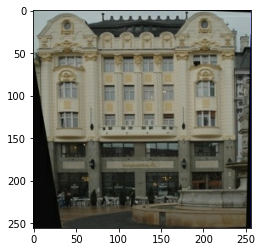

In [8]:
inp, real = read_image(str(PATH / 'train/2.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(real / 255.0)

In [9]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
BATCH_SIZE = 1
img_w=256
img_h=256
channel=3
K.backend.clear_session()

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [10]:
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, size=[height, width],method="nearest")
    real_image = tf.image.resize(target_image,size= [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

@tf.function
def random_jittering_mirroring(input_image, target_image):
    
    #resizing to 286x286
    input_image,target_image = resize(input_image,target_image, height=286, width=286)
    
    #cropping (random jittering) to 256x256
    input_image=tf.image.random_crop(input_image, size=[img_h, img_w, 3])
    target_image=tf.image.random_crop(target_image, size=[img_h, img_w, 3])
    
    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
        
        
    return input_image, target_image

def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image



def load_preprocess_train(image_path):
    input_image, target_image = read_image(image_path)
    input_image, target_image = random_jittering_mirroring(input_image, target_image)
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image    



def load_preprocess_test(image_path):
    input_image, target_image = read_image(image_path)
    input_image, target_image = resize(input_image, target_image,256,256)
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image    

In [11]:
inp,real_mirror=random_jittering_mirroring(inp,real)

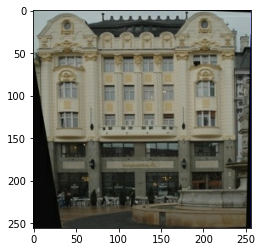

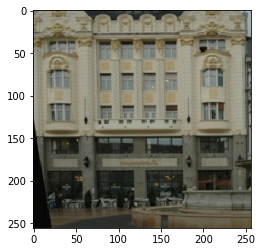

In [12]:
plt.figure()
plt.imshow(real / 255.0)
plt.figure()
plt.imshow(real_mirror / 255.0)

In [13]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
test_dataset = test_dataset.map(load_preprocess_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
for x,y in test_dataset.take(1):
    print(x.shape)
    print(y.shape)
    break

(1, 256, 256, 3)
(1, 256, 256, 3)


# PATCH DISCRIMINATOR

 PatchGAN is designed based on the size of the receptive field

In [16]:
def downsample(filters,k_size,apply_batchnorm=True):
    init_w=K.initializers.RandomNormal(stddev=0.02)
    
    x=K.Sequential([
        K.layers.Conv2D(filters=filters,kernel_size=k_size,strides=2,padding='same',use_bias=False,
                        kernel_initializer=init_w)
    ])
    if apply_batchnorm:
        x.add(K.layers.BatchNormalization())
    
    x.add(K.layers.LeakyReLU(0.2))
    return x

In [ ]:
def Discriminator():
    init_w = tf.random_normal_initializer(stddev=0.02)
    
    input_imgs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    target_imgs = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([input_imgs, target_imgs])  
    down1 = downsample(64, 4, False)(x)  
    down2 = downsample(128, 4)(down1)  
    down3 = downsample(256, 4)(down2)  

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=init_w,use_bias=False)(zero_pad1) 

    b1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(b1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=init_w)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[input_imgs, target_imgs], outputs=last)

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [17]:
def upsample(inputs,filters,k_size,skips,apply_dropout=False):
    init_w=K.initializers.RandomNormal(stddev=0.02)
    upsample=K.layers.Conv2DTranspose(filters,k_size,strides=2,padding='same',use_bias=False,kernel_initializer=init_w)(inputs)
    upsample=K.layers.BatchNormalization()(upsample)
    if apply_dropout:
        upsample=K.layers.Dropout(0.5)(upsample)
    merge=K.layers.Concatenate()([skips,upsample])
    output=K.layers.Activation('relu')(merge)
    return output


In [18]:
def Generator():
    init_w=tf.random_normal_initializer(stddev=0.02)
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    # encoders
    
    e1=downsample(64, 4, apply_batchnorm=False)(inputs)  
    e2=downsample(128, 4)(e1)
    e3=downsample(256, 4)(e2)
    e4=downsample(512, 4)(e3)
    e5=downsample(512, 4)(e4)
    e6=downsample(512, 4)(e5)
    e7=downsample(512, 4)(e6)
    # bottleneck
    b=K.layers.Conv2D(512,4,strides=2,padding='same',use_bias=False,kernel_initializer=init_w,activation='relu')(e7)
    #decoders
    d1=upsample(b,512, 4,e7, apply_dropout=True)
    d2=upsample(d1,512, 4,e6, apply_dropout=True)
    d3=upsample(d2,512, 4,e5, apply_dropout=True)
    d4=upsample(d3,512, 4,e4)
    d5=upsample(d4,256, 4,e3)
    d6=upsample(d5,128, 4,e2)
    d7=upsample(d6,64, 4,e1)
  
    output=K.layers.Conv2DTranspose(3, 4,strides=2,padding='same',use_bias=False,kernel_initializer=init_w,
                                    activation='tanh')(d7)
    return K.Model(inputs=inputs,outputs=output)

In [19]:
generator=Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

 activation_4 (Activation)      (None, 32, 32, 512)  0           ['concatenate_4[0][0]']          
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 64, 64, 128)  1048576    ['activation_4[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_11 (BatchN  (None, 64, 64, 128)  512        ['conv2d_transpose_5[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 concatenate_5 (Concatenate)    (None, 64, 64, 256)  0           ['sequential_1[0][0]',           
                                                                  'batch_normalization_11[0][0]'] 
          

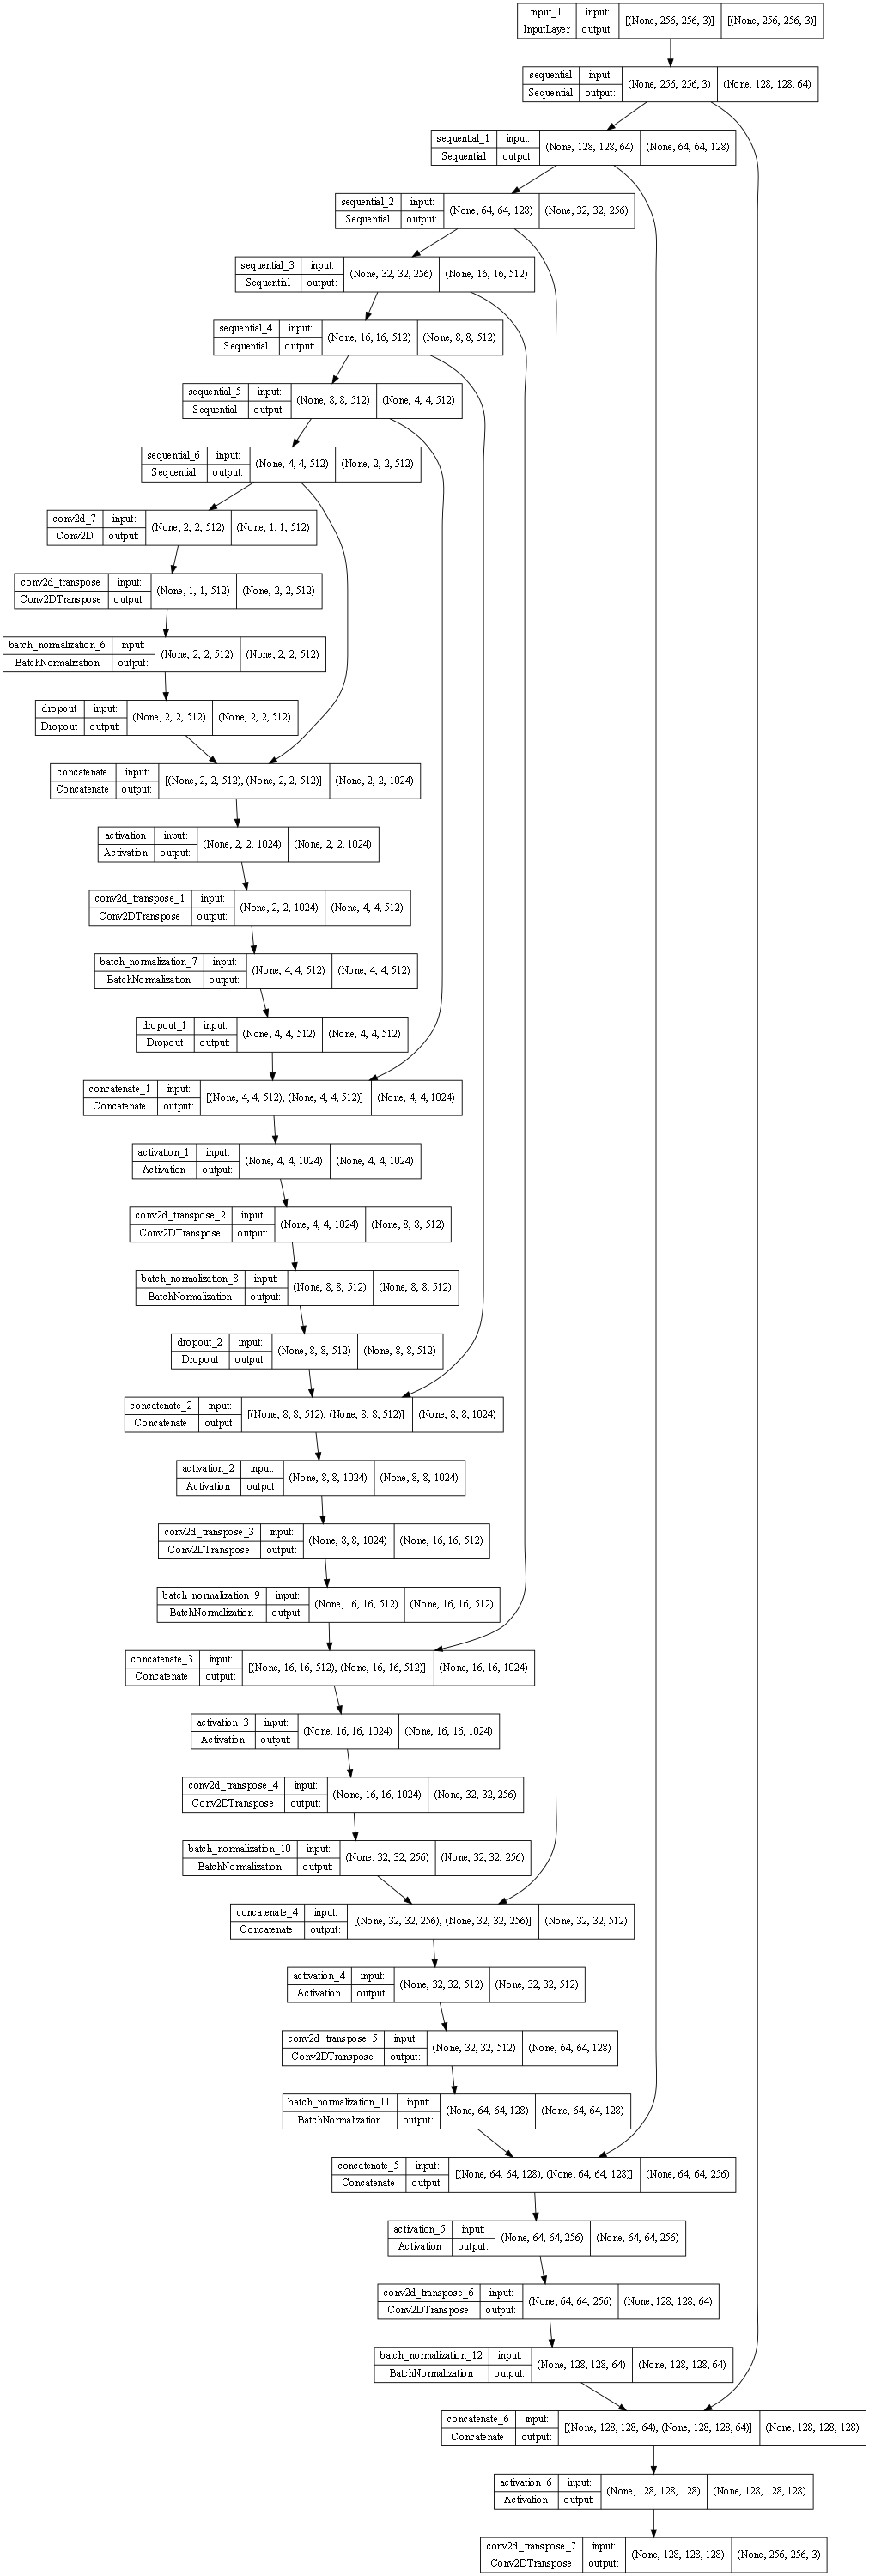

In [25]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


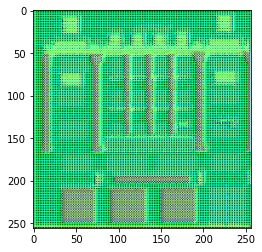

In [20]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

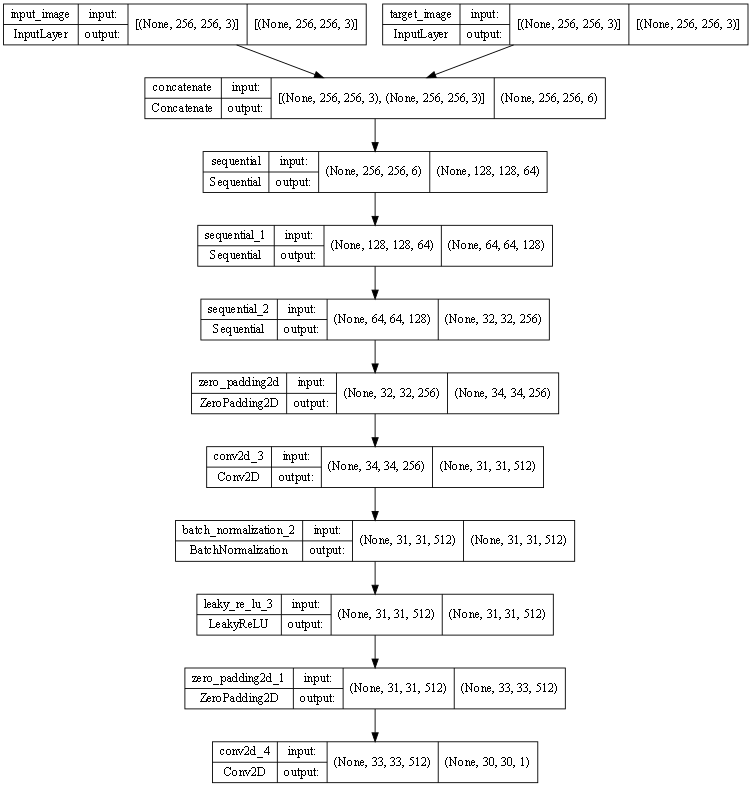

In [23]:
#K.layers.Input?
K.backend.clear_session()

In [29]:
class Pix2Pix(K.Model):
    def __init__(self,discriminator,generator,lambda_):
        super(Pix2Pix,self).__init__()
        self.discriminator=discriminator
        self.generator=generator
        self.bce_loss=K.losses.BinaryCrossentropy()
        self.d_loss_metric=K.metrics.Mean(name='d_loss')
        self.g_loss_metric=K.metrics.Mean(name='g_loss')
        self.lambda_=lambda_
    @property    
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]
    
    def compile(self,d_optimizer,g_optimizer):
        super(Pix2Pix,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        
    def generator_loss(self,fake_output,gen_img,target):
        gen_loss=self.bce_loss(tf.ones_like(fake_output),fake_output)
        l1_loss=tf.reduce_mean(tf.abs(target-gen_img))
        total_loss=gen_loss+self.lambda_*l1_loss
        return total_loss
    
    def discriminator_loss(self,real_output,fake_output):
        real_l=self.bce_loss(tf.ones_like(real_output),real_output)
        fake_l=self.bce_loss(tf.zeros_like(fake_output),fake_output)
        total_loss=real_l+fake_l
        return total_loss
    
    def train_step(self,data):
        input_imgs,target_imgs=data
        with tf.GradientTape() as tape:
            generated_imgs=self.generator(input_imgs)
            fake_output_=self.discriminator([input_imgs,generated_imgs])
            real_output_=self.discriminator([input_imgs,target_imgs])
            d_loss=self.discriminator_loss(real_output_,fake_output_)
        d_grads=tape.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))
        
        with tf.GradientTape() as tape:
            generated_imgs_=self.generator(input_imgs)
            fake_output_=self.discriminator([input_imgs,generated_imgs])
            g_loss=self.generator_loss(fake_output_,generated_imgs_,target_imgs)
        g_grads=tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss':self.d_loss_metric.result(),'g_loss':self.g_loss_metric.result()}
        
        

In [120]:
len(train_dataset)

400

In [121]:
pix2pix=Pix2Pix(discriminator,generator,lambda_=100)
pix2pix.compile(d_optimizer=K.optimizers.Adam(2e-4, beta_1=0.5),g_optimizer=K.optimizers.Adam(2e-4, beta_1=0.5))

In [ ]:
pix2pix.fit(train_dataset,epochs=20)

In [ ]:
input_, target_ = next(iter(test_dataset.take(1)))
gen=pix2pix.generator.predict(input_)
input_=tf.reshape(input_,shape=(256,256,3))
target_=tf.reshape(target_,shape=(256,256,3))
gen=tf.reshape(gen,shape=(256,256,3))
plt.figure(figsize=(25,20))

plt.subplot(151),plt.imshow(input_),plt.title('inputs'),plt.axis('off')
plt.subplot(152),plt.imshow(target_),plt.title('ground truth'),plt.axis('off')
plt.subplot(153),plt.imshow(gen),plt.title('predicted'),plt.axis('off')
plt.show()

In [ ]:
input_, target_ = next(iter(test_dataset.take(1)))
gen=pix2pix.generator.predict(input_)
input_=tf.reshape(input_,shape=(256,256,3))
target_=tf.reshape(target_,shape=(256,256,3))
gen=tf.reshape(gen,shape=(256,256,3))
plt.figure(figsize=(25,20))

plt.subplot(151),plt.imshow(input_),plt.title('inputs'),plt.axis('off')
plt.subplot(152),plt.imshow(target_),plt.title('ground truth'),plt.axis('off')
plt.subplot(153),plt.imshow(gen),plt.title('predicted'),plt.axis('off')
plt.show()

  **REFERENCE**

- [pix2pix-Tensorflow](https://www.tensorflow.org/tutorials/generative/pix2pix)

- [ Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004)

